In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

data= pd.read_csv("/content/drive/MyDrive/Cyberbullying_Kaggle_Data/cyberbullying_tweets.csv")

In [91]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


**Phase 1: EDA to see distribution of** **Tweets**

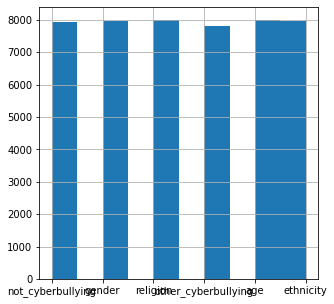

In [92]:
#Distribution of tweets
data.cyberbullying_type.hist() #Histogram shows that the dataset is balanced and has equal representation for all labels

In [93]:
temp = data.groupby('cyberbullying_type').count().reset_index().sort_values(by='tweet_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,cyberbullying_type,tweet_text
5,religion,7998
0,age,7992
2,gender,7973
1,ethnicity,7961
3,not_cyberbullying,7945
4,other_cyberbullying,7823


In [94]:
#Funnel-Chart for better visualization
from plotly import graph_objs as go
fig = go.Figure(go.Funnelarea(
    text =temp,
    values = temp.tweet_text,
    title = {"position": "top center", "text": "Funnel-Chart of Bullying Type Distribution"}
    ))
fig.show()

**Word Cloud of tweets for EDA**

In [95]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [96]:
text = " ".join(review for review in data.tweet_text)

# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update([])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

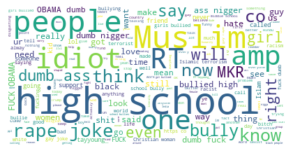

In [97]:
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

**Phase 2: Building a base model for multi-class classification**

TEXT PREPROCESSING

In [98]:
# import TweetTokenizer() method from nltk
from nltk.tokenize import TweetTokenizer

# Create a reference variable for Class TweetTokenizer
tk = TweetTokenizer()

#Preprocessing: Tweet Tokenizer + lowercase conversion
data["tokens"]= data["tweet_text"].apply(lambda x: tk.tokenize(x.lower()))


In [99]:
#Recover Hashtags
data["hastags"]= data["tokens"].apply(lambda x: [item for item in x if item.startswith("#")])

In [100]:
#number of words in a tweet
data["length"]= data["tokens"].apply(lambda x: len(x))

In [101]:
#Remove Stop-words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
data['remove_stopwords'] = data['tokens'].apply(lambda x: [item for item in x if item not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
data.head()

,tweet_text,cyberbullying_type,tokens,hastags,length,remove_stopwords
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[in, other, words, #katandandre, ,, your, food...","[#katandandre, #mkr]",11,"[words, #katandandre, ,, food, crapilicious, !..."
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[why, is, #aussietv, so, white, ?, #mkr, #theb...","[#aussietv, #mkr, #theblock, #imacelebrityau, ...",15,"[#aussietv, white, ?, #mkr, #theblock, #imacel..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[@xochitlsuckkks, a, classy, whore, ?, or, mor...",[],11,"[@xochitlsuckkks, classy, whore, ?, red, velve..."
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[@jason_gio, meh, ., :p, thanks, for, the, hea...",[],21,"[@jason_gio, meh, ., :p, thanks, heads, ,, con..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[@rudhoeenglish, this, is, an, isis, account, ...",[],21,"[@rudhoeenglish, isis, account, pretending, ku..."


In [103]:
#Lemmatisation to get root words
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words, remove numbers

data['lemmatise'] = data['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x if y.isalpha()]) 

data.head(5)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,tweet_text,cyberbullying_type,tokens,hastags,length,remove_stopwords,lemmatise
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[in, other, words, #katandandre, ,, your, food...","[#katandandre, #mkr]",11,"[words, #katandandre, ,, food, crapilicious, !...","[word, food, crapilicious]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[why, is, #aussietv, so, white, ?, #mkr, #theb...","[#aussietv, #mkr, #theblock, #imacelebrityau, ...",15,"[#aussietv, white, ?, #mkr, #theblock, #imacel...",[white]
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[@xochitlsuckkks, a, classy, whore, ?, or, mor...",[],11,"[@xochitlsuckkks, classy, whore, ?, red, velve...","[classy, whore, red, velvet, cupcake]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[@jason_gio, meh, ., :p, thanks, for, the, hea...",[],21,"[@jason_gio, meh, ., :p, thanks, heads, ,, con...","[meh, thanks, head, concerned, another, angry,..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[@rudhoeenglish, this, is, an, isis, account, ...",[],21,"[@rudhoeenglish, isis, account, pretending, ku...","[isi, account, pretending, kurdish, account, l..."


Feature Engineering - BOWs and TF-IDF

In [104]:
#Bag of words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2))
                            
# join the processed data to be vectorised

vectors = []

for index, row in data.iterrows():
    vectors.append(", ".join(row[6]))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised)
vectorised.shape

  (0, 349799)	1
  (0, 109807)	1
  (0, 67564)	1
  (0, 349938)	1
  (0, 109826)	1
  (1, 345397)	1
  (2, 55943)	1
  (2, 346352)	1
  (2, 257261)	1
  (2, 335795)	1
  (2, 70031)	1
  (2, 55965)	1
  (2, 346388)	1
  (2, 257307)	1
  (2, 335796)	1
  (3, 196340)	1
  (3, 314074)	1
  (3, 137514)	1
  (3, 61531)	1
  (3, 12001)	1
  (3, 11378)	1
  (3, 85866)	1
  (3, 328507)	1
  (3, 196352)	1
  (3, 314153)	1
  :	:
  (47690, 354872)	1
  (47690, 267528)	1
  (47690, 115723)	1
  (47690, 331449)	1
  (47691, 266162)	1
  (47691, 128637)	1
  (47691, 113561)	1
  (47691, 38193)	1
  (47691, 82995)	1
  (47691, 31207)	1
  (47691, 86310)	1
  (47691, 182772)	1
  (47691, 52653)	1
  (47691, 171012)	1
  (47691, 31591)	1
  (47691, 83043)	1
  (47691, 214455)	1
  (47691, 266468)	1
  (47691, 214578)	1
  (47691, 86622)	1
  (47691, 52686)	1
  (47691, 38229)	1
  (47691, 128654)	1
  (47691, 114145)	1
  (47691, 171014)	1


(47692, 358428)

In [105]:
# initisalise LDA Model
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components = 10, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

# column names

topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

data = pd.merge(data, df_document_topic, left_index = True, right_index = True, how = 'outer')
data['Dominant_topic']=data['Dominant_topic'].astype(int)
display(data.head(10))

,tweet_text,cyberbullying_type,tokens,hastags,length,remove_stopwords,lemmatise,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Dominant_topic
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[in, other, words, #katandandre, ,, your, food...","[#katandandre, #mkr]",11,"[words, #katandandre, ,, food, crapilicious, !...","[word, food, crapilicious]",0.02,0.02,0.85,0.02,0.02,0.02,0.02,0.02,0.02,0.02,3
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[why, is, #aussietv, so, white, ?, #mkr, #theb...","[#aussietv, #mkr, #theblock, #imacelebrityau, ...",15,"[#aussietv, white, ?, #mkr, #theblock, #imacel...",[white],0.55,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,1
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[@xochitlsuckkks, a, classy, whore, ?, or, mor...",[],11,"[@xochitlsuckkks, classy, whore, ?, red, velve...","[classy, whore, red, velvet, cupcake]",0.01,0.01,0.01,0.01,0.91,0.01,0.01,0.01,0.01,0.01,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[@jason_gio, meh, ., :p, thanks, for, the, hea...",[],21,"[@jason_gio, meh, ., :p, thanks, heads, ,, con...","[meh, thanks, head, concerned, another, angry,...",0.01,0.01,0.94,0.01,0.01,0.01,0.01,0.01,0.01,0.01,3
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[@rudhoeenglish, this, is, an, isis, account, ...",[],21,"[@rudhoeenglish, isis, account, pretending, ku...","[isi, account, pretending, kurdish, account, l...",0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.94,0.01,9
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying,"[@raja5aab, @quickieleaks, yes, ,, the, test, ...",[],26,"[@raja5aab, @quickieleaks, yes, ,, test, god, ...","[yes, test, god, good, bad, indifferent, weird...",0.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying,"[itu, sekolah, ya, bukan, tempat, bully, !, ga...",[],11,"[itu, sekolah, ya, bukan, tempat, bully, !, ga...","[itu, sekolah, ya, bukan, tempat, bully, ga, j...",0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.95,10
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying,"[karma, ., i, hope, it, bites, kat, on, the, b...",[#mkr],17,"[karma, ., hope, bites, kat, butt, ., nasty, ....","[karma, hope, bite, kat, butt, nasty]",0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.92,10
8,@stockputout everything but mostly my priest,not_cyberbullying,"[@stockputout, everything, but, mostly, my, pr...",[],6,"[@stockputout, everything, mostly, priest]","[everything, mostly, priest]",0.02,0.02,0.02,0.02,0.02,0.02,0.85,0.02,0.02,0.02,7
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying,"[rebecca, black, drops, out, of, school, due, ...",[],10,"[rebecca, black, drops, school, due, bullying, :]","[rebecca, black, drop, school, due, bullying]",0.35,0.01,0.01,0.01,0.01,0.01,0.01,0.25,0.01,0.34,1


In [106]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
LE.fit(data['cyberbullying_type'])
data['target'] = LE.transform(data['cyberbullying_type'])
data.head()

,tweet_text,cyberbullying_type,tokens,hastags,length,remove_stopwords,lemmatise,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Dominant_topic,target
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[in, other, words, #katandandre, ,, your, food...","[#katandandre, #mkr]",11,"[words, #katandandre, ,, food, crapilicious, !...","[word, food, crapilicious]",0.02,0.02,0.85,0.02,0.02,0.02,0.02,0.02,0.02,0.02,3,3
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[why, is, #aussietv, so, white, ?, #mkr, #theb...","[#aussietv, #mkr, #theblock, #imacelebrityau, ...",15,"[#aussietv, white, ?, #mkr, #theblock, #imacel...",[white],0.55,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,1,3
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[@xochitlsuckkks, a, classy, whore, ?, or, mor...",[],11,"[@xochitlsuckkks, classy, whore, ?, red, velve...","[classy, whore, red, velvet, cupcake]",0.01,0.01,0.01,0.01,0.91,0.01,0.01,0.01,0.01,0.01,5,3
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[@jason_gio, meh, ., :p, thanks, for, the, hea...",[],21,"[@jason_gio, meh, ., :p, thanks, heads, ,, con...","[meh, thanks, head, concerned, another, angry,...",0.01,0.01,0.94,0.01,0.01,0.01,0.01,0.01,0.01,0.01,3,3
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[@rudhoeenglish, this, is, an, isis, account, ...",[],21,"[@rudhoeenglish, isis, account, pretending, ku...","[isi, account, pretending, kurdish, account, l...",0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.94,0.01,9,3


**BASE Model: *Multinomial Naive Bayes'***

Split data into train and test

In [107]:
from sklearn.model_selection import train_test_split
x = data['tweet_text']
y = data['cyberbullying_type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((38153,), (9539,), (38153,), (9539,))

In [108]:
x_train[:5]

27942    RT @avatastic: @freebsdgirl Also, anyone who h...
13988    @Questionnier is dis a joke gay rape or babe rape
30197    RT @DavidCleevely: Raspberry Pi Foundation loo...
47342    STOLEN // reply and ill give you one = luv ur ...
43358    People in Navarre are so fucking dumb there wa...
Name: tweet_text, dtype: object

In [109]:
y_train[:5]

27942    other_cyberbullying
13988                 gender
30197    other_cyberbullying
47342              ethnicity
43358              ethnicity
Name: cyberbullying_type, dtype: object

In [110]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

Model1 = Pipeline([("tfidf", TfidfVectorizer()), ("clf", MultinomialNB())])
Model1.fit(x_train, y_train)
Model1.score(x_test, y_test)

0.7342488730474892

In [111]:
from sklearn.feature_extraction.text import CountVectorizer
Model2 = Pipeline([("BOWs", CountVectorizer()), ("clf", MultinomialNB())])
Model2.fit(x_train, y_train)
Model2.score(x_test, y_test)

0.7564734248873047

In [112]:
from sklearn.neighbors import KNeighborsClassifier
Model_Knn = Pipeline([("BOWs", CountVectorizer()), ("clf", KNeighborsClassifier())])
Model_Knn.fit(x_train, y_train)
Model_Knn.score(x_test, y_test)

0.6168361463465772

In [113]:
from sklearn.ensemble import RandomForestClassifier
ModelRf1 = Pipeline([("tfidf", TfidfVectorizer()), ("clf", RandomForestClassifier(n_estimators=100))])
ModelRf1.fit(x_train, y_train)
ModelRf1.score(x_test, y_test)

0.8071076632770731

In [114]:
from sklearn.ensemble import RandomForestClassifier
ModelRf2 = Pipeline([("BOWs", CountVectorizer()), ("clf", RandomForestClassifier(n_estimators=100))])
ModelRf2.fit(x_train, y_train)
ModelRf2.score(x_test, y_test)

0.8063738337351923

In [115]:
import xgboost as xgb
from xgboost import XGBClassifier
Modelxgb = Pipeline([("BOWs", CountVectorizer()), ("clf", XGBClassifier())])
Modelxgb.fit(x_train, y_train)
Modelxgb.score(x_test, y_test)

0.8212600901562008

In [116]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred= Modelxgb.predict(x_test)

print("Classification report for XGB:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for XGB:",accuracy_score(y_test, y_pred))

Classification report for XGB:
                      precision    recall  f1-score   support

                age       0.99      0.98      0.98      1603
          ethnicity       0.99      0.97      0.98      1603
             gender       0.93      0.77      0.84      1531
  not_cyberbullying       0.70      0.40      0.51      1624
other_cyberbullying       0.53      0.89      0.67      1612
           religion       0.97      0.92      0.95      1566

           accuracy                           0.82      9539
          macro avg       0.85      0.82      0.82      9539
       weighted avg       0.85      0.82      0.82      9539

Confusion Matrix: 
 [[1565    0    3   16   19    0]
 [   0 1556    3    5   38    1]
 [   0    2 1179  115  234    1]
 [  13    3   20  648  901   39]
 [   5    4   46  114 1442    1]
 [   0    2   13   31   76 1444]]
Micro F1 score for XGB: 0.8212600901562008


In [117]:
#Random Forest
y_pred= ModelRf1.predict(x_test)

print("Classification report for Random Forest:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for Random Forest:",accuracy_score(y_test, y_pred))

Classification report for Random Forest:
                      precision    recall  f1-score   support

                age       0.96      0.98      0.97      1603
          ethnicity       0.98      0.97      0.98      1603
             gender       0.90      0.80      0.85      1531
  not_cyberbullying       0.56      0.49      0.52      1624
other_cyberbullying       0.53      0.66      0.59      1612
           religion       0.95      0.95      0.95      1566

           accuracy                           0.81      9539
          macro avg       0.82      0.81      0.81      9539
       weighted avg       0.81      0.81      0.81      9539

Confusion Matrix: 
 [[1576    1    3   11   12    0]
 [   7 1553    2   11   23    7]
 [   5    4 1232  118  170    2]
 [  34    7   48  795  685   55]
 [  19    7   71  439 1062   14]
 [   0    5    9   37   34 1481]]
Micro F1 score for Random Forest: 0.8071076632770731


In [118]:
y_pred= Model2.predict(x_test)

print("Classification report for Multinomial Naive Bayes':\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for Multinomial Naive Bayes':",accuracy_score(y_test, y_pred))

Classification report for Multinomial Naive Bayes':
                      precision    recall  f1-score   support

                age       0.70      0.99      0.82      1603
          ethnicity       0.86      0.90      0.88      1603
             gender       0.81      0.85      0.83      1531
  not_cyberbullying       0.69      0.36      0.47      1624
other_cyberbullying       0.66      0.49      0.56      1612
           religion       0.78      0.97      0.87      1566

           accuracy                           0.76      9539
          macro avg       0.75      0.76      0.74      9539
       weighted avg       0.75      0.76      0.74      9539

Confusion Matrix: 
 [[1585    4    5    2    0    7]
 [  74 1441   10    2   11   65]
 [  31   31 1295   81   52   41]
 [ 286   84  133  578  349  194]
 [ 271  110  156  161  794  120]
 [  14    6    6   16    1 1523]]
Micro F1 score for Multinomial Naive Bayes': 0.7564734248873047


In [119]:
y_pred= Model_Knn.predict(x_test)

print("Classification report for KNN':\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for KNN:",accuracy_score(y_test, y_pred))

Classification report for KNN':
                      precision    recall  f1-score   support

                age       0.88      0.91      0.90      1603
          ethnicity       0.95      0.76      0.84      1603
             gender       0.67      0.67      0.67      1531
  not_cyberbullying       0.35      0.42      0.38      1624
other_cyberbullying       0.37      0.58      0.45      1612
           religion       0.95      0.36      0.53      1566

           accuracy                           0.62      9539
          macro avg       0.70      0.62      0.63      9539
       weighted avg       0.69      0.62      0.63      9539

Confusion Matrix: 
 [[1466    4    6   62   60    5]
 [  53 1216   35  148  137   14]
 [  18   12 1028  201  268    4]
 [  37    6  171  677  730    3]
 [  13    8  182  478  929    2]
 [  76   37  106  377  402  568]]
Micro F1 score for KNN: 0.6168361463465772


In [125]:
from sklearn.linear_model import SGDClassifier

Model_sgd = Pipeline([('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
Model_sgd.fit(x_train, y_train)
Model_sgd.score(x_test, y_test)

y_pred = Model_sgd.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7840444491036797
                     precision    recall  f1-score   support

                age       0.81      0.99      0.89      1603
          ethnicity       0.89      0.97      0.93      1603
             gender       0.85      0.83      0.84      1531
  not_cyberbullying       0.64      0.43      0.52      1624
other_cyberbullying       0.66      0.51      0.57      1612
           religion       0.78      0.98      0.87      1566

           accuracy                           0.78      9539
          macro avg       0.77      0.79      0.77      9539
       weighted avg       0.77      0.78      0.77      9539



In [130]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('XGBoost', XGBClassifier()), ('RF', RandomForestClassifier()), ('MNB',MultinomialNB() ), ("SGD", SGDClassifier(alpha=1e-3, random_state=42, max_iter=5, tol=None))],voting='hard', weights=[3,2,1,1])
Model_Voting =  Pipeline([('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', eclf),
               ])
Model_Voting.fit(x_train, y_train)
y_pred= Model_Voting.predict(x_test)

print("Classification report for Ensemble Classifier':\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for Ensemble Classifier:",accuracy_score(y_test, y_pred))

Classification report for Ensemble Classifier':
                      precision    recall  f1-score   support

                age       0.97      0.98      0.98      1603
          ethnicity       0.98      0.98      0.98      1603
             gender       0.90      0.82      0.86      1531
  not_cyberbullying       0.69      0.45      0.54      1624
other_cyberbullying       0.58      0.82      0.68      1612
           religion       0.95      0.96      0.95      1566

           accuracy                           0.83      9539
          macro avg       0.84      0.83      0.83      9539
       weighted avg       0.84      0.83      0.83      9539

Confusion Matrix: 
 [[1578    1    3   10   11    0]
 [   1 1568    3    6   22    3]
 [   1    3 1259  112  155    1]
 [  29   10   54  726  739   66]
 [  12   14   71  187 1316   12]
 [   0    3   11   18   38 1496]]
Micro F1 score for Ensemble Classifier: 0.8326868644512003
